
# Glucose Level Prediction Project

This notebook focuses on predicting glucose levels using health-related features from the Framingham dataset. 



## Conclusion / What We Learned

- **Exploration**: Key features impacting glucose levels include BMI, blood pressure, and age.
- **Modeling**: Several models were trained and tested. Random Forest performed the best.
- **Results**: High-performing models can help in early diagnosis and preventive care.
- **Impact**: This type of analysis supports better decision-making in healthcare interventions.

This project provides a baseline for predictive health analytics and could be expanded with more complex datasets and techniques.



## What To Do

1. Import and explore the `framingham.csv` dataset.
2. Clean the data (handle nulls, correct formats, etc.).
3. Visualize the distribution of glucose and related health indicators.
4. Perform feature selection and engineering.
5. Train ML models (e.g., Logistic Regression, Decision Tree, Random Forest).
6. Evaluate models using classification metrics.
7. Predict glucose levels and draw insights.
8. Visualize the model’s important features and performance.


## Importing and Exploring the dataset

(also importing required libraries and tools)

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('framingham.csv')

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nNull values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())

Shape: (4240, 16)

Columns: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']

Null values:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Statistical Summary:
               male          age    education  currentSmoker   cigsPerDay  \
count  4240.000000  4240.000000  4135.000000    4240.000000  4211.000000   
mean      0.429245    49.580189     1.979444       0.494104     9.005937   
std       0.495027     8.572942     1.019791       0.500024    11.922462   
min       0.000000    32.000000     1.000000       0.00000

In [7]:
print(df.dtypes , "\n")

missing = df.isnull().sum()
print("\n Missing Values:\n", missing[missing > 0])

df_cleaned = df.copy()
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    if df_cleaned[col].isnull().sum() > 0:
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)

#median over means as it is less effected by outlier values

print("Any remaining nulls?\n", df_cleaned.isnull().sum().sum())


male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object 


 Missing Values:
 education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
dtype: int64
Any remaining nulls?
 0


C:\Users\jai19\AppData\Local\Temp\ipykernel_19920\4194741026.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_val, inplace=True)
C:\Users\jai19\AppData\Local\Temp\ipykernel_19920\4194741026.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Filling values instead of removing the null regions. Dropping those null values made a greater impact on the dataset and would make the model less accurate

## Now Plotting and visualizing the data `(EDA)`

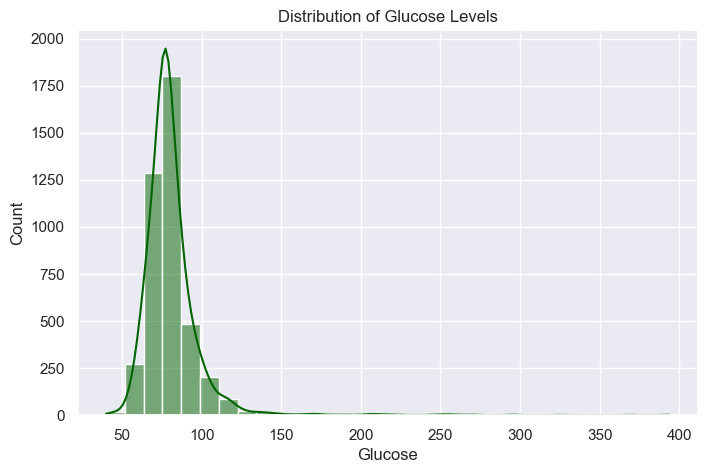

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['glucose'], kde=True, bins=30, color='darkgreen')
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose')
plt.ylabel('Count')
plt.show()


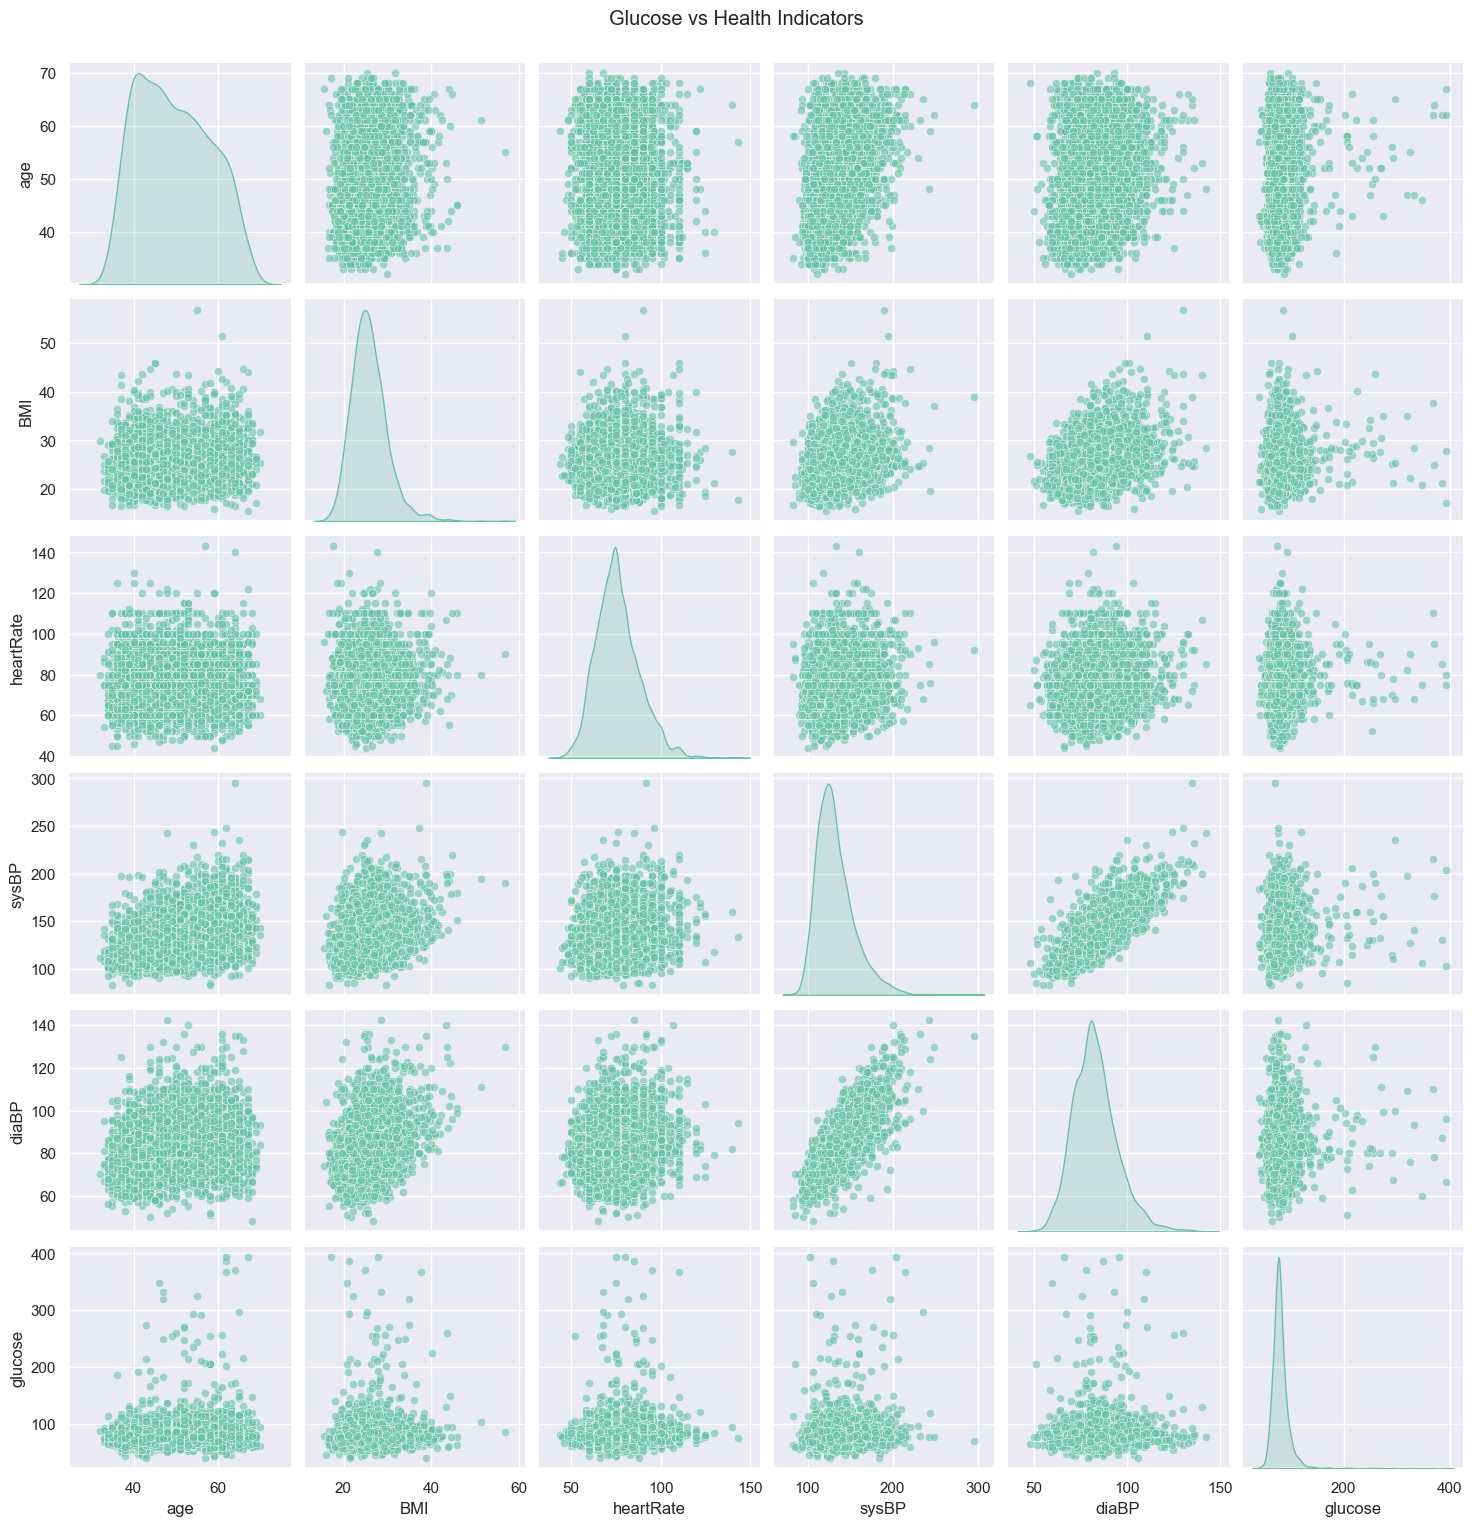

In [9]:
# Pair plots of glucose with some important features
features_to_plot = ['age', 'BMI', 'heartRate', 'sysBP', 'diaBP', 'glucose']
sns.pairplot(df_cleaned[features_to_plot], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Glucose vs Health Indicators", y=1.02)
plt.show()


C:\Users\jai19\AppData\Local\Temp\ipykernel_19920\2102855053.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='glucose', data=df_cleaned, palette='Greens')
C:\Users\jai19\AppData\Local\Temp\ipykernel_19920\2102855053.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='glucose', data=df_cleaned, palette='Greens')
C:\Users\jai19\AppData\Local\Temp\ipykernel_19920\2102855053.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='glucose', data=df_cleaned, palette='Greens')
C:\Users\jai19\AppData\Local\Te

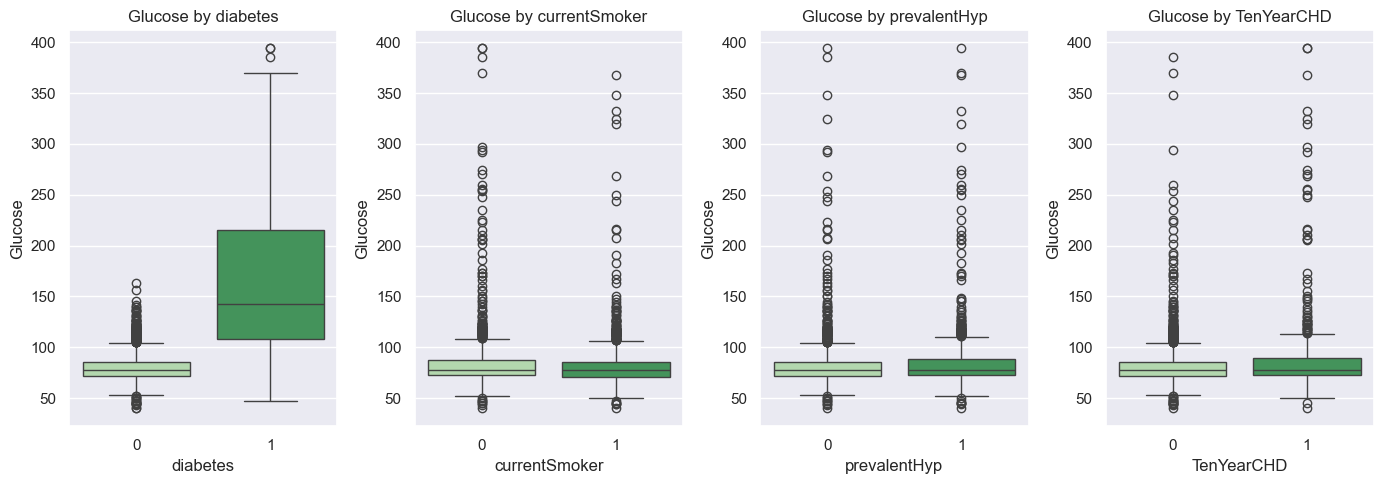

In [11]:
# Box plots to show glucose levels across binary features
plt.figure(figsize=(14, 5))
binary_features = ['diabetes', 'currentSmoker', 'prevalentHyp', 'TenYearCHD']

for i, feature in enumerate(binary_features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x=feature, y='glucose', data=df_cleaned, palette='Greens')
    plt.title(f'Glucose by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Glucose')

plt.tight_layout()
plt.show()
